In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference a vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
logging.getLogger().addHandler(logging.FileHandler("logging.tmp.txt"))

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'zeta': 1 - (-.02)**2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 2

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       zeta=true_params['zeta'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                  theta=true_params['equity_price'])})

## We start by examining the distributions of simulated data

In [6]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [7]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

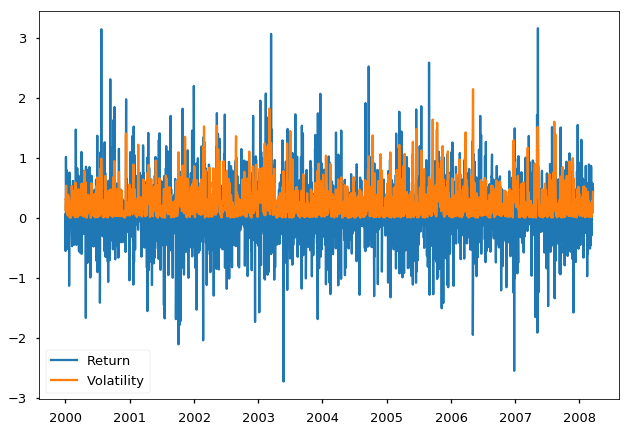

In [8]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


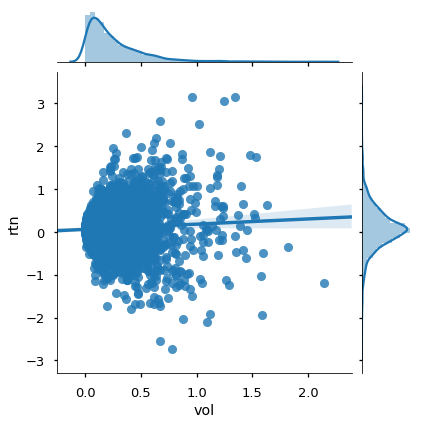

In [9]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [10]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.256410,0.088922
std,0.249433,0.516219
min,0.000083,-2.728556
25%,0.081424,-0.178588
50%,0.177437,0.071617
75%,0.357628,0.351124
max,2.139588,3.155502


## The Asymptotic Distributions in the Strongly Identified Case

In [31]:
data_arr = np.array([(true_params, vl.simulate_data(time_dim=time_dim, **true_params)) 
                     for _ in tqdm.tnrange(sim_dim)])

In [35]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr[:,1]), total=len(data_arr)))

In [36]:
omega, omega_cov = est_arr[0]

In [37]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,0.000901,0.000000,-0.000067,-0.000655,0.000000,0.000000,0.00000
delta,0.000000,0.002086,0.000000,0.000000,-0.000439,-0.000081,0.00000
gamma,-0.000067,0.000000,0.000019,-0.000002,0.000000,0.000000,0.00000
psi,-0.000655,0.000000,-0.000002,0.001871,0.000000,0.000000,0.00000
rho,0.000000,-0.000439,0.000000,0.000000,0.000359,-0.000013,0.00000
scale,0.000000,-0.000081,0.000000,0.000000,-0.000013,0.000013,0.00000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00062


In [82]:
def is_in_confidence_set(omega, omega_cov, true_params, vol_dim=10, equity_dim=10, equity_max=2, vol_min=-15, 
                         use_tqdm=True):
 
    omega_cov_in = pd.DataFrame.from_dict(omega_cov)
    
    qlr_stats = vl.compute_qlr_stats(omega=omega, omega_cov=omega_cov_in, vol_dim=vol_dim,
                                     equity_dim=equity_dim,equity_max=equity_max, vol_min=vol_min,
                                     use_tqdm=use_tqdm)
    qlr_draws = vl.compute_qlr_sim(omega=omega, omega_cov=omega_cov_in, vol_dim=vol_dim,
                                   equity_dim=equity_dim, equity_max=equity_max, vol_min=vol_min,
                                   use_tqdm=use_tqdm)
    accepted_vals = (qlr_stats < qlr_draws).stack().reset_index().rename(columns={0:'value'}).query(
        'value').drop('value', axis='columns')
    
    hull1 = spatial.ConvexHull(accepted_vals.values)
    hull2 = spatial.ConvexHull(np.row_stack([accepted_vals.values,
                                         [true_params['vol_price'], true_params['equity_price']]]))
    
    return true_params, int(np.all(hull1.simplices == hull2.simplices))

In [83]:
omega_estimates = [(omega, omega_cov.to_dict(), true_params) 
                   for (true_params, data), (omega, omega_cov) in zip(data_arr, est_arr)]

In [84]:
import json 

In [85]:
with open("../results/omega_estimates.tmp.json", "w") as write_file:
    json.dump(omega_estimates, write_file)

In [86]:
with open('../results/omega_estimates.tmp.json', 'r') as read_file:
    estimats = json.load(read_file)
    
results = [is_in_confidence_set(omega=omega, omega_cov=omega_cov, true_params=true_params) 
           for omega, omega_cov, true_params in tqdm.tqdm_notebook(omega_estimates)]

with open('../results/confidence_set_coverage.tmp.json', 'w') as write_file:
    json.dump(results, write_file)